## Source Code

The CVSearch class constructs a grid solver which accepts a model and a parameter grid (dictionary
of parameter: value_list, pairs) upon instantiation, following SciKit API conventions. It exposes
the fit method which performs fold generation and search across the parameter grid, returning
a list containing the average of the model’s scoring function on all five folds for each parameter
combination.

The RidgeRegression class constructs a model, also following SciKit conventions, which provides the
fit, score, and predict methods. The RidgeRegression class accepts the optional named parameter
lambda_ on instantiation, defaulting to 10e-1.

The helper functions standardize, one_hot_encode and shuffle all assist in data processing. All
helpers assume a Pandas DataFrame input.


In [3]:
import pandas as pd
import numpy as np
from random import uniform
import matplotlib.pyplot as plt
from random import randrange
from copy import deepcopy

In [1]:
# center/scale each column
def standardize(X, mu=None, sigma=None):
    if mu is None or sigma is None:
        for col, mean in X.mean().items():
            if X[col].dtype != np.int32:
                X[col] = (X[col] - mean) / X[col].std()
    elif sigma is None:
        for col in X.columns:
            if X[col].dtype != object:
                X[col] = (X[col] - mu) / X[col].std()
    elif mu is None:
        for col, mean in X.mean().items():
            if X[col].dtype != object:
                X[col] = (X[col] - mean) / sigma
    else:
        for col in X.columns:
            if X[col].dtype != object:
                X[col] = (X[col] - mu) / sigma
                
    return X

def one_hot_encode(df):
    one_hot = df.copy()
    categories = {}
    #acquiring categorical features and their unique values
    for col, dtype in zip(one_hot.columns, one_hot.dtypes):
        if dtype == object:
            categories[col] = one_hot[col].unique()
            
    # casting bool mask to integers 0, 1
    # assumes binary categories
    for col, values in categories.items():
        mask = one_hot[col] == sorted(values)[::-1][0]
        
        # putting pertinent category metadata in header
        if "Yes" not in values:
            one_hot.drop(col, inplace=True, axis=1)
            col = values[0]
        one_hot[col] = mask.astype(int)
        
    return one_hot

def shuffle(df):
    sampled = df.copy()
    n = df.shape[0]
    
    memo = []
    idxs = []
    # random sampling indexs without replacement
    for _ in range(n):
        rand = randrange(n)
        
        # index uniqueness
        while rand in memo:
            rand = randrange(n)
        memo.append(rand)
        idxs.append(rand)
        
    sampled = df.reindex(idxs)
    sampled.reset_index(inplace=True, drop=True)
    
    return sampled

MSE = lambda y_true, y_pred: sum([(truth-pred)**2 for truth, pred in zip(y_true, y_pred)]) / len(y_true)

In [7]:
class RidgeRegression:
    terms = np.array([])
    lambda_ = np.nan
    alpha = np.nan
    params = {"lambda_": lambda_, "alpha": alpha}
    
    def __init__(self, lambda_=10, alpha=(10E-5)/10):
        self.lambda_ = lambda_
        self.alpha = alpha
        self.X = np.array([])
        self.y_true = np.array([])
        self.params = {"lambda_": self.lambda_, "alpha": self.alpha}
        
    def fit(self, X, y_true):
        self.X = X
        self.y_true = y_true
        
        p = X.shape[1]
        terms_prev = [0]*p
        iters = 1000
        i = 0
        
        self.terms = np.array([uniform(-1, 1) for _ in range(p)])
        
        while not np.array_equal(terms_prev, self.terms) and i < iters:
            terms_prev = self.terms.copy()
            self.terms -= (2 * self.alpha * np.subtract(self.lambda_*self.terms, np.dot(X.T, np.subtract(self.y_true, np.dot(X, self.terms)))))
            i += 1
            
        print(f"{i} iters completed ")
        
    def predict(self, X):
        return np.dot(X, self.terms)

    def score(self, X=[], y_true=[]):
        if not len(y_true):
            y_true = self.y_true
            X = self.X
        return MSE(y_true, self.predict(X))

In [6]:
class CVSearch:
    """Grid solver for models supporting fit and score methods, following SciKit API conventions."""
    constructor = None
    n_folds = 0
    fold_size = 0
    params = {}
    folds = []
    cat_idxs = []
    
    def __init__(self, model_constructor, params, n_folds=5):
        self.constructor = model_constructor
        self.n_folds = n_folds
        self.params = params
        self.cat_idxs = []
        
    def get_folds(self, X, y_true):
        X_folds = []
        y_true_folds = []
        
        if X.shape[0] != y_true.shape[0]:
            print("unequal row count between data and labels")
            return False
        
        self.fold_size = X.shape[0]//self.n_folds
        shapes = np.ndarray((self.n_folds,))
        
        print(f"performing {self.n_folds}-fold CV with {self.fold_size} observations a fold")
        for i in range(self.n_folds):
            # slicing dataset on calculated fold indices
            start = i*self.fold_size
            end = (i+1)*self.fold_size
            
            y_true_folds.append(y_true[start:end])
            X_folds.append(X[start:end])
            shapes[i] = end-start # filling verification arr
            
        # organizing folds
        for i in range(len(X_folds)):
            X_copy = deepcopy(X_folds)
            y_copy = deepcopy(y_true_folds)
            X_holdout = X_copy.pop(i)
            y_holdout = y_copy.pop(i)

            # stack
            X_copy, y_copy = np.concatenate(X_copy), np.concatenate(y_copy)

            # normalize folds
            mus = [col.mean() for col in X_copy.T]
            sigmas = [col.std() for col in X_copy.T]
            for col, mu, sigma in zip(range(X.shape[1]), mus, sigmas):
                if col not in self.cat_idxs:
                    X_holdout[:,col] = (X_holdout[:,col]-mu)/sigma
                    X_copy[:,col] = (X_copy[:,col]-mu)/sigma

            # center response
            y_holdout = y_holdout - y_copy.mean()
            y_copy = y_copy - y_copy.mean()

            self.folds.append(((X_copy, y_copy), (X_holdout, y_holdout)))
        
        # confirming fold size equivalence (400%5==0)
        if not (shapes == self.fold_size).all():
            print("warning: not all folds of equal size")
            
    def search(self):
        for param, values in self.params.items():
            if param in self.constructor.params.keys():
                print(f"Searching parameter {param}:")
                
                scores = {}
                for value in values:
                    print("{}: {:G}: ".format(param, value))
                    model = self.constructor(**{param: value})
                    fold_scores = []
                    i = 1
                    for test, validation in self.folds:
                        print(f"fold {i}:", end=" ")
                        model.fit(*test)
                        score = model.score(*validation)
                        fold_scores.append(score)
                        i += 1
                        
                    scores[value] = np.mean(fold_scores)
                    print("score: {:G}".format(scores[value]), end="\n\n")
                    
                min_idx = np.nanargmin(scores.values())
                
                min_value, min_score = list(scores.items())[min_idx]
                print(f"best {param}:\n {min_value}\n {min_score}")
            else:
                print(f"{param} not in model {self.model}")
                
        return scores
    
    def fit(self, X, y_true):
        cat_idxs = []
        for i, dtype in enumerate(X.dtypes):
            if dtype == np.int32:
                cat_idxs.append(i)
                
        self.cat_idxs = cat_idxs
        self.get_folds(X.to_numpy(), y_true.to_numpy())
        return self.search()

In [5]:
df = pd.read_csv("data/Credit_N400_p9.csv")
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [8]:
sampled = shuffle(df)
sampled.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,45.120,3762,287,3,80,8,Male,No,Yes,70
1,39.116,2150,173,4,75,15,Male,No,No,0
2,148.924,9504,681,3,36,11,Female,No,No,964
3,12.096,4100,307,3,32,13,Male,No,Yes,560
4,27.349,2000,169,4,51,16,Female,No,Yes,0


In [9]:
one_hot = one_hot_encode(sampled)
one_hot.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Male
0,45.120,3762,287,3,80,8,0,1,70,1
1,39.116,2150,173,4,75,15,0,0,0,1
2,148.924,9504,681,3,36,11,0,0,964,0
3,12.096,4100,307,3,32,13,0,1,560,1
4,27.349,2000,169,4,51,16,0,1,0,0


In [10]:
raw_y_true = one_hot.Balance
raw_X = one_hot.drop("Balance", axis=1)
raw_X.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Male
0,45.120,3762,287,3,80,8,0,1,1
1,39.116,2150,173,4,75,15,0,0,1
2,148.924,9504,681,3,36,11,0,0,0
3,12.096,4100,307,3,32,13,0,1,1
4,27.349,2000,169,4,51,16,0,1,0


In [11]:
y_true = raw_y_true - raw_y_true.mean()
X = standardize(raw_X)
X.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Male
0,-0.002806,-0.421801,-0.439104,0.030993,1.410596,-1.743885,0,1,1
1,-0.173160,-1.120181,-1.175899,0.760241,1.120737,0.495967,0,0,1
2,2.942467,2.065853,2.107363,0.030993,-1.140158,-0.783948,0,0,0
3,-0.939809,-0.275366,-0.309842,0.030993,-1.372044,-0.143990,0,1,1
4,-0.507029,-1.185167,-1.201752,0.760241,-0.270583,0.815946,0,1,0


## Coefficient Plot

In [12]:
terms = []
samples = 100
lambdas = np.logspace(-2, 4, samples)
for curr_lambda_ in lambdas:
    model = RidgeRegression(lambda_=curr_lambda_)
    model.fit(X.to_numpy(), y_true.to_numpy())
    print("MSE: {:G}".format(model.score()), end="\n\n")
    terms.append(model.terms)

1000 iters completed 
MSE: 14548.5

1000 iters completed 
MSE: 14546.1

1000 iters completed 
MSE: 14527.4

1000 iters completed 
MSE: 14536.8

1000 iters completed 
MSE: 14539.6

1000 iters completed 
MSE: 14549.6

1000 iters completed 
MSE: 14540

1000 iters completed 
MSE: 14543

1000 iters completed 
MSE: 14559.9

1000 iters completed 
MSE: 14533.7

1000 iters completed 
MSE: 14522.8

1000 iters completed 
MSE: 14534.7

1000 iters completed 
MSE: 14553.8

1000 iters completed 
MSE: 14552.3

1000 iters completed 
MSE: 14546.2

1000 iters completed 
MSE: 14526.4

1000 iters completed 
MSE: 14564.7

1000 iters completed 
MSE: 14565.2

1000 iters completed 
MSE: 14542.3

1000 iters completed 
MSE: 14556.3

1000 iters completed 
MSE: 14542.7

1000 iters completed 
MSE: 14568.5

1000 iters completed 
MSE: 14583.9

1000 iters completed 
MSE: 14583.8

1000 iters completed 
MSE: 14562.6

1000 iters completed 
MSE: 14584.7

1000 iters completed 
MSE: 14590.8

1000 iters completed 
MSE: 14605

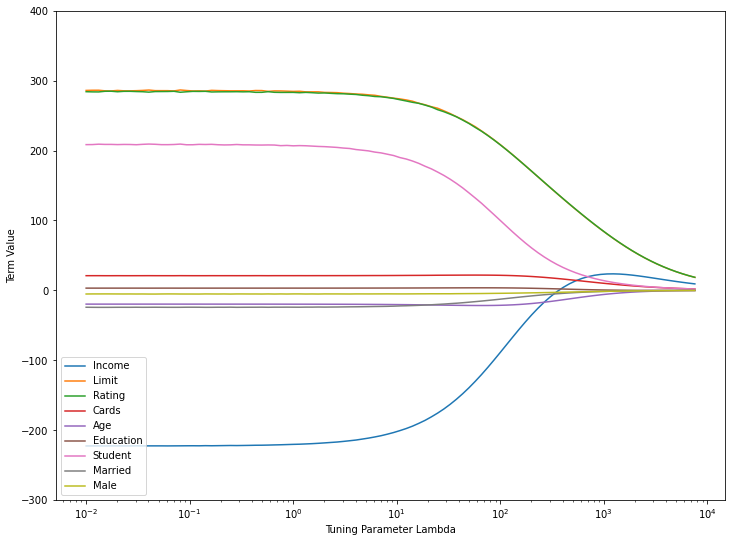

In [13]:
plt.figure(figsize=(12,9))
i = 2
plt.plot(lambdas[:-i], terms[:-i])
plt.xscale("log")
plt.legend(list(X.columns), loc='lower left')
plt.ylim(-300, 400)
plt.ylabel("Term Value")
plt.xlabel("Tuning Parameter Lambda")
plt.show()

## CV Error

In [14]:
cv = CVSearch(RidgeRegression, {"lambda_": lambdas})

In [15]:
scores = cv.fit(raw_X, raw_y_true)

performing 5-fold CV with 80 observations a fold
Searching parameter lambda_:
lambda_: 0.01: 
fold 1: 1000 iters completed 
fold 2: 1000 iters completed 
fold 3: 1000 iters completed 
fold 4: 1000 iters completed 
fold 5: 1000 iters completed 
score: 18134.6

lambda_: 0.0114976: 
fold 1: 1000 iters completed 
fold 2: 1000 iters completed 
fold 3: 1000 iters completed 
fold 4: 1000 iters completed 
fold 5: 1000 iters completed 
score: 18156.4

lambda_: 0.0132194: 
fold 1: 1000 iters completed 
fold 2: 1000 iters completed 
fold 3: 1000 iters completed 
fold 4: 1000 iters completed 
fold 5: 1000 iters completed 
score: 18146

lambda_: 0.0151991: 
fold 1: 1000 iters completed 
fold 2: 1000 iters completed 
fold 3: 1000 iters completed 
fold 4: 1000 iters completed 
fold 5: 1000 iters completed 
score: 18153.3

lambda_: 0.0174753: 
fold 1: 1000 iters completed 
fold 2: 1000 iters completed 
fold 3: 1000 iters completed 
fold 4: 1000 iters completed 
fold 5: 1000 iters completed 
score: 181

fold 1: 780 iters completed 
fold 2: 766 iters completed 
fold 3: 778 iters completed 
fold 4: 780 iters completed 
fold 5: 874 iters completed 
score: 144773

lambda_: 2477.08: 
fold 1: 662 iters completed 
fold 2: 672 iters completed 
fold 3: 671 iters completed 
fold 4: 666 iters completed 
fold 5: 1000 iters completed 
score: 150472

lambda_: 2848.04: 
fold 1: 582 iters completed 
fold 2: 599 iters completed 
fold 3: 597 iters completed 
fold 4: 621 iters completed 
fold 5: 586 iters completed 
score: 155942

lambda_: 3274.55: 
fold 1: 522 iters completed 
fold 2: 520 iters completed 
fold 3: 523 iters completed 
fold 4: 521 iters completed 
fold 5: 502 iters completed 
score: 161144

lambda_: 3764.94: 
fold 1: 455 iters completed 
fold 2: 459 iters completed 
fold 3: 452 iters completed 
fold 4: 457 iters completed 
fold 5: 439 iters completed 
score: 166048

lambda_: 4328.76: 
fold 1: 389 iters completed 
fold 2: 400 iters completed 
fold 3: 404 iters completed 
fold 4: 386 iters

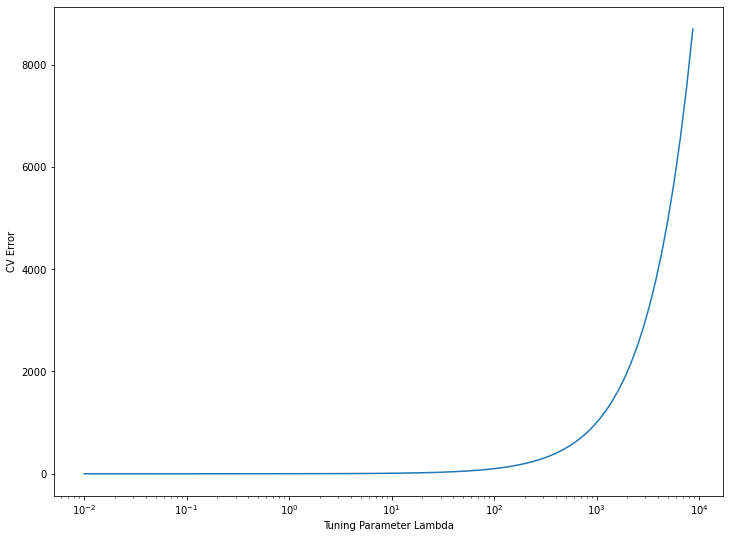

In [16]:
plt.figure(figsize=(12,9))
i = 1
plt.plot(lambdas[:-i], list(scores)[:-i])
plt.xscale("log")
plt.ylabel("CV Error")
plt.xlabel("Tuning Parameter Lambda")
plt.show()

## Optimal λ

The observed optimal λ value is 10e-1, with a MSE of 18208.1 averaged across all folds.

## Model Parameter Estimates

In [17]:
model = RidgeRegression(lambda_=10E-1)
model.fit(X.to_numpy(), y_true)
print(model.terms)

1000 iters completed 
[-220.47919801  285.5299338   282.36669401   21.01047556  -19.81393841
    3.15465955  206.86479487  -24.0980254    -5.18279744]


##  SciKit Implementation

In [24]:
from sklearn.linear_model import Ridge, RidgeCV
terms = []
for curr_lambda_ in lambdas:
    model = Ridge(alpha=curr_lambda_)
    model.fit(X.to_numpy(), y_true.to_numpy())
    print("MSE: {:G}".format(model.score(X.to_numpy(), y_true.to_numpy())), end="\n\n")
    terms.append(model.coef_)

MSE: 0.954935

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954934

MSE: 0.954933

MSE: 0.954933

MSE: 0.954932

MSE: 0.954932

MSE: 0.954931

MSE: 0.95493

MSE: 0.954929

MSE: 0.954927

MSE: 0.954925

MSE: 0.954922

MSE: 0.954918

MSE: 0.954914

MSE: 0.954909

MSE: 0.954902

MSE: 0.954894

MSE: 0.954884

MSE: 0.954873

MSE: 0.954858

MSE: 0.954841

MSE: 0.954821

MSE: 0.954796

MSE: 0.954767

MSE: 0.954732

MSE: 0.95469

MSE: 0.95464

MSE: 0.954578

MSE: 0.954503

MSE: 0.95441

MSE: 0.954294

MSE: 0.95415

MSE: 0.953969

MSE: 0.953741

MSE: 0.953454

MSE: 0.953092

MSE: 0.952636

MSE: 0.952064

MSE: 0.951348

MSE: 0.950456

MSE: 0.94935

MSE: 0.947987

MSE: 0.946319

MSE: 0.944293

MSE: 0.941849

MSE: 0.938925

MSE: 0.935458

MSE: 0.931382

MSE: 0.926631

MSE: 0.921144

MSE: 0.914862

MSE: 0.907734

MSE: 0.899719

MSE: 0.890786

MSE: 0.880916

MSE: 0.870106

MSE: 0.858366

MSE: 0.845719

M

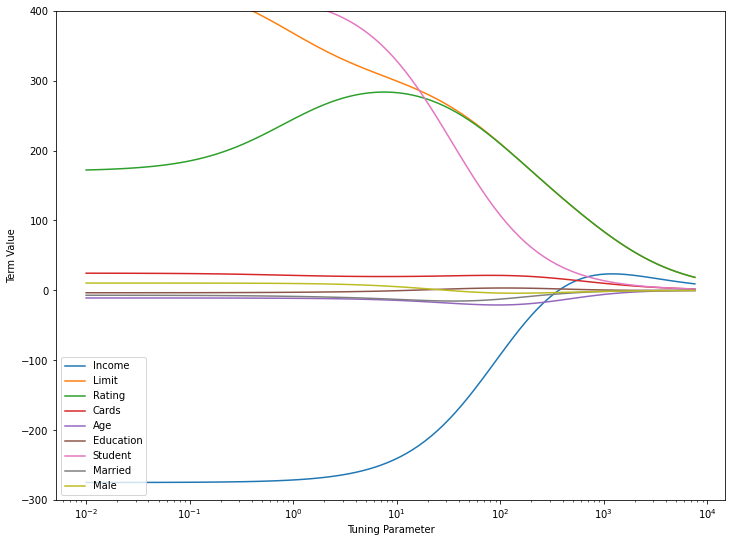

In [20]:
plt.figure(figsize=(12,9))
i = 2
plt.plot(lambdas[:-i], terms[:-i])
plt.xscale("log")
plt.legend(list(X.columns), loc='lower left')
plt.ylim(-300, 400)
plt.ylabel("Term Value")
plt.xlabel("Tuning Parameter")
plt.show()

In [23]:
scores_sci = []
for lambda_ in lambdas:
    cv = RidgeCV(fit_intercept=False, cv=5, alphas=[lambda_])
    cv.fit(X, y_true)
    scores_sci.append(MSE(cv.predict(X), y_true))

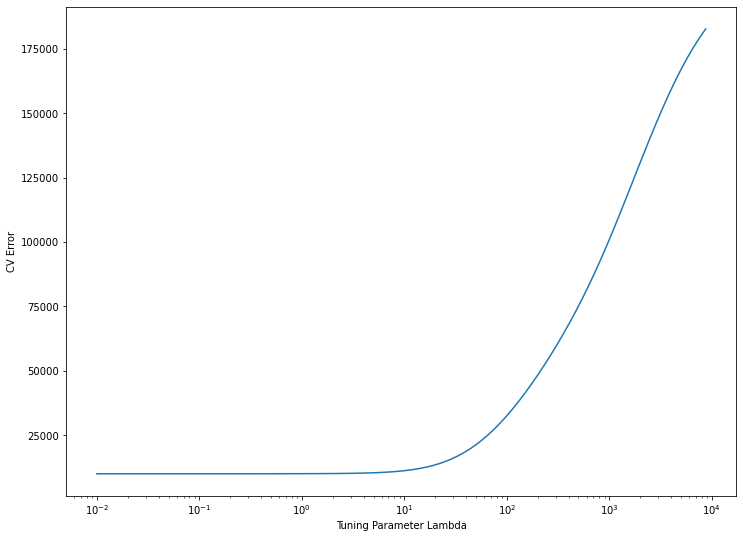

In [22]:
plt.figure(figsize=(12,9))
i = 1
plt.plot(lambdas[:-i], scores_sci[:-i])
plt.ylabel("CV Error")
plt.xlabel("Tuning Parameter Lambda")
plt.xscale("log")
plt.show()